# О вероятности попасть под удар фигуры, поставленной случайным образом на шахматную доску


На шахматную доску случайным образом поставлены две фигуры. С какой вероятностью первая фигура бьёт вторую? В данном ноутбуке представлен расчёт этой вероятности для каждой шахматной фигуры как функции от размера доски. Рассмотрены только квадратные доски. Фигуры полагаются поставленными одновременно (обязательно стоят на разных клетках), выбор каждого из полей равновероятен.

Степень (валентность) вершины $v$ графа $G$ - количество рёбер графа $G$, инцидентных вершине $v$.

Граф ходов шахматной фигуры (далее Граф) - граф, изображающий все возможные ходы фигуры на шахматной доске - каждая вершина соответствует клетке на доске, а рёбра соответствуют возможным ходам.
Тогда валентность вершины Графа - количество полей, которые бьёт фигура, будучи поставленной на соответствующую этой вершине клетку. В целях упрощения речи далее в тексте используется формулировка "клетка имеет валентность", однако понятно, что валентность имеет не клетка, а соответствующая ей вершина в Графе.

Если событие $X$ может произойти только при выполнении одного из событий $H_1, H_2,..., H_n$, которые образуют полную группу несовместных событий, то вероятность $P(X)$ вычисляется по формуле: $$P(X) = P(H_1) \cdot P(X|H_1) + P(H_2) \cdot P(X|H_2) + ... + P(H_n) \cdot P(X|H_n),$$ которая называется формулой полной вероятности.

Пусть событие $X_{piece}$ = «Первая *фигура (piece)* бьёт вторую на доске размера $n\times n$», $a$ - некоторое значение валентности, $b$ - количество клеток, имеющих валентность $a$, каждая из гипотез $H_i$ = «Первая фигура стоит на клетке с валентностью $a_i$». Тогда $P(H_i) = \frac{b_i}{n^{2}}$ в силу классического определения вероятности - это отношение количества исходов, благоприятствующих событию $H_i$, к количеству всех равновозможных исходов. $P(X_{piece}|H_i) = \frac{a_i}{n^{2}-1}$ по той же причине - событию $X_{piece}$ при условии $H_i$ благоприятствует $a_i$ исходов (вторая фигура стоит под ударом клетки с валентностью $a_i$),а количество всех равновозможных исходов уменьшилось на единицу, так как одна из клеток уже занята первой фигурой.

### Импорты

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from string import ascii_uppercase as alphabet

### Функция создания доски

Создание доски как пустого массива заданной формы. Также нам понадобится массив такой же формы для хранения цвета надписи на клетках.
Заполнение доски: 0 - чёрные клетки, 1 - белые.

In [2]:
def get_board(board_size):

    x, y = np.meshgrid(range(board_size), range(board_size))

    board = np.empty(shape=(board_size, board_size), dtype='uint8')
    text_colors = np.empty_like(board, dtype='<U5')

    # force left bottom corner cell to be black
    if board_size % 2 == 0:
        extra_term = 1
    else:
        extra_term = 0

    for i, j in zip(x.flatten(), y.flatten()):
        board[i, j] = (i + j + extra_term) % 2
        # text color should be the opposite to a cell color
        text_colors[i, j] = 'black' if board[i, j] else 'white'

    return board, text_colors

In [3]:
def get_valencies(piece, board):
    # Get valencies for the given piece on the given board
    valencies = np.empty_like(board)

    if piece == 'Pawn':
        valencies = pawn(valencies)

    elif piece == 'Knight':
        valencies = knight(valencies)

    elif piece == 'Rook':
        valencies = rook(valencies)

    elif piece == 'King':
        valencies = king(valencies)

    else:
        valencies = bishop_or_queen(piece, valencies)

    return valencies

### Функция рисования доски

Функция создаёт изображение шахматной доски, каждая клетка которой подписана соответствующим значением валентности.

In [4]:
def plot_board(board, text_colors, piece):

    board_size = np.shape(board)[0]

    x, y = np.meshgrid(range(board_size), range(board_size))

    # let figure size be dependent on the board size
    plt.figure(figsize=(3*board_size/4, 3*board_size/4))
    ax = plt.subplot(111)

    ax.imshow(board, cmap='gray', interpolation='none')

    # Display valency (degree) values
    val_board = get_valencies(piece, board)

    for i, j, valency, text_col in zip(x.flatten(), y.flatten(),
                                       val_board.flatten(),
                                       text_colors.flatten()):
        ax.text(i, j, str(valency), color=text_col,
                va='center', ha='center', fontsize=20)

    ax.set_xticks(np.arange(board_size+1))  # one tick per cell
    ax.set_xticklabels(alphabet[:board_size])  # set letters as ticklabels
    # one tick per cell
    ax.set_yticks(np.arange(board_size+1))
    # set numbers as ticklabels (upside down)
    ax.set_yticklabels(np.arange(board_size, 0, -1))

    ax.axis('tight')  # get rid of the white spaces on the edges
    ax.set_title(piece, fontsize=30)
    plt.show()

## Пешка

### Функция, возвращающая массив валентностей пешечного Графа

Иллюстрирует изложенные ниже соображения.

In [5]:
def pawn(valencies):

    valencies[0, :] = 0  # empty horizontal line
    valencies[1:, 0] = valencies[1:, -1] = 1  # vertical edges
    valencies[1:, 1:-1] = 2

    return valencies

Рассмотрим несколько частных случаев в поисках закономерности.

In [6]:
def special_cases(piece, board_sizes):
    ''' Plot boards of every board_size,
    contained in board_sizes list for given piece.
    '''
    for board_size in board_sizes:
        board, text_colors = get_board(board_size=board_size)
        plot_board(board, text_colors, piece=piece)

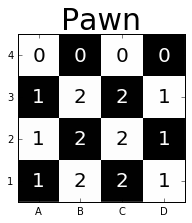

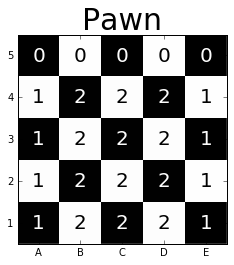

In [7]:
special_cases(piece='Pawn', board_sizes=range(4,6))

Закономерность очевидна - всегда присутствует горизонталь (верхняя или нижняя - в зависимости от цвета фигуры), с которой пешка не бьёт ни одну клетку - все поля этой горизонтали $0$-валентны. Их количество равно $n$. 
На крайних вертикалях расположены $1$-валентные клетки, которых $2(n-1)$ штук.
Все остальные поля - $2$-валентны, и расположены они прямоугольником размера $(n-1)\times(n-2)$.

Тогда $$ P(X_{pawn}) = \frac{n\cdot 0}{n^{2}(n^{2}-1)} + \frac{2(n-1)\cdot 1}{n^{2}(n^{2}-1)} + \frac{(n-1)(n-2)\cdot 2}{n^{2}(n^{2}-1)}= \frac{2(n-1)({\color{Green}1}+n-{\color{Green}2})}{n^{2}(n^{2}-1)} = \frac{2(n-1)^{2}}{n^{2}(n^{2}-1)}. $$ Так как $(n^{2}-1) = (n+1)(n-1)$, $$ P(X_{pawn}) = \frac{2(n-1)}{n^{2}(n+1)}. $$

## Конь

### Функция, возвращающая массив валентностей Графа коня

In [8]:
def knight(valencies):

    board_size = valencies.shape[0]

    if board_size > 3:
        # Four points in each corner are the same for any board size > 3.
    
        # corner cells
        valencies[0, 0] = valencies[0, -1] = \
            valencies[-1, 0] = valencies[-1, -1] = 2

        # cells horizontally/vertically adjacent to the corners
        valencies[0, 1] = valencies[1, 0] = \
            valencies[0, -2] = valencies[1, -1] = \
            valencies[-2, 0] = valencies[-1, 1] = \
            valencies[-2, -1] = valencies[-1, -2] = 3

        # cells diagonally adjacent
        valencies[1, 1] = valencies[1, -2] = \
            valencies[-2, 1] = valencies[-2, -2] = 4

        if board_size > 4:

            valencies[0, 2:-2] = valencies[2:-2, 0] = \
               valencies[2:-2, -1] = valencies[-1, 2:-2] = 4

            valencies[1, 2:-2] = valencies[2:-2, 1] = \
                valencies[2:-2, -2] = valencies[-2, 2:-2] = 6
            
            valencies[2:-2, 2:-2] = 8

    # Patholigical cases
    elif board_size == 3:
        valencies = 2 * np.ones((board_size, board_size), dtype='uint8')
        valencies[1, 1] = 0

    else:
        valencies = np.zeros((board_size, board_size), dtype='uint8')

    return valencies

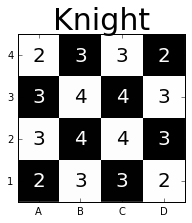

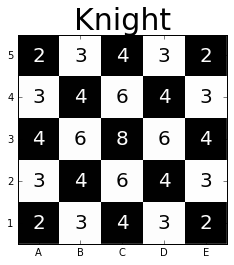

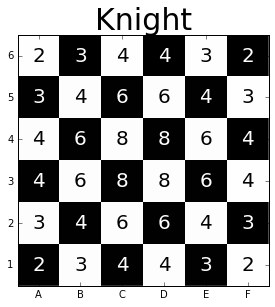

In [9]:
special_cases(piece='Knight', board_sizes=[4,5,6])

Количество $2$- и $3$-валентных клеток фиксировано при любом $n\geq 4$. Первые расположены в углах, а вторые прилегают к ним по вертикали и горизонтали. Стало быть, количество $2$-валентных клеток равно $4$, а $3$-валентных - $8$, вдвое больше. $4$-валентные клетки образуют арифметическую прогрессию с начальным элементом $4$ и шагом $4$ для всех $n\geq 4$ (при увеличении $n$ на единицу с каждой стороны появляется одна $4$-валентная клетка). Легко видеть, что рост количества $6$-валентных клеток устроен аналогично, однако существуют они только при $n\geq 5$. Таким образом, $4$-валентных клеток $4(n-3)$, а $6$-валентных клеток - $4(n-4)$ штук. Количество $8$-валентных клеток растёт квадратично, к тому же, они существуют только при $n\geq 5$. То есть, их количество - $(n-4)^2$. Итого имеем:

$$ P(X_{knight}) = \frac{4\cdot 2}{n^{2}(n^{2}-1)} + \frac{8\cdot 3}{n^{2}(n^{2}-1)} + \frac{4(n-3)\cdot 4}{n^{2}(n^{2}-1)} +$$ $$ + \frac{4(n-4)\cdot 6}{n^{2}(n^{2}-1)} + \frac{(n-4)^2\cdot 8}{n^{2}(n^{2}-1)} = \frac{32 + 24(n-4) + 16(n-3) + 8(n-4)^{2}}{n^{2}(n^{2}-1)} = $$ 
$$ \frac{8(4+3(n-4)+2(n-3)+(n-4)^{2})}{n^{2}(n^{2}-1)} = \frac{8({\color{Green} 4}+{\color{Red} {3n}}-{\color{Green} {12}}+{\color{Red} {2n}} - {\color{Green} 6}+ n^{2}-{\color{Red} {8n}}+{\color{Green} {16}})}{n^{2}(n^{2}-1)} = $$ 
$$= \frac{8(n^{2}-3n+2)}{n^{2}(n^{2}-1)} = \frac{8(n-1)(n-2)}{n^{2}(n^{2}-1)} = \frac{8(n-2)}{n^{2}(n+1)}. $$

## Офицер

### Функция, возвращающая массив валентностей Графа офицера (и ферзя)

Расположение валентностей для офицера и ферзя практически идентично, за исключением того, что наименьшее значение валентности для ферзя в три раза превышает оное для офицера.

In [10]:
def bishop_or_queen(piece, valencies):
    
    board_size = np.shape(valencies)[0]
    
    if piece == 'Bishop':
        smallest_val = board_size-1

    else:
        smallest_val = 3*(board_size-1)
    
    # external square
    valencies[0, :] = valencies[:, 0] = \
        valencies[:, -1] = valencies[-1, :] = smallest_val
    
    # internal sqares
    for i in range (1, int(board_size/2)+1):
        # top, left
        # right, bottom
        valencies[i, i:-i] = valencies[i:-i, i] = \
            valencies[i:-i, -(i+1)] = valencies[-(i+1), i:-i] = \
            smallest_val + 2*i
        
    return valencies

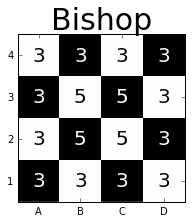

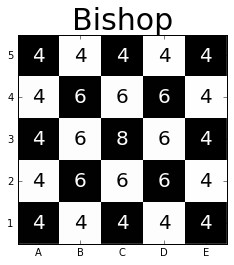

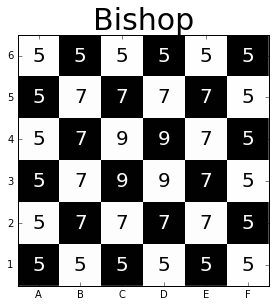

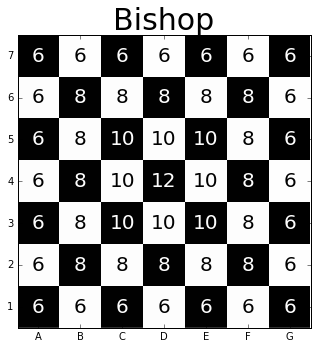

In [11]:
special_cases(piece='Bishop', board_sizes=range(4,8))

Видно, что эквивалентные клетки располагаются по периметрам образованных клетками концентрических квадратов, при чём валентность возрастает с шагом $2$ по мере приближения к центру. Поскольку при чётных $n$ в центре доски расположены $4$ поля с максимальной валентностью, а при нечётных - одно, случаи чётных и нечётных $n$ представляется удобным рассмотреть раздельно.

### Чётные $n$

Каково количество различных значений валентности, а также их величина? Наименьшее значение равно $(n-1)$, так как это количество клеток на диагонали минус клетка, на которой стоит сама фигура. Наибольшее значение -  $(n-1) + (n-2) = (2n-3)$, так как оно больше наименьшего значения на количество клеток, расположенных на диагонали квадрата со стороной $(n-1)$ минус клетка, на которой стоит сама фигура. 

Пусть $s$ - количество шагов размера $2$, которое требуется совершить для перехода от значения $(n-1)$ к значению $(2n-3)$. Тогда
$$ n-1 + 2s = 2n-3, $$ $$ 2s = {\color{Red} {2n}} - {\color{Green} 3} - {\color{Red} n} + {\color{Green} 1} = n - 2 \Rightarrow s = \frac{n-2}{2}. $$
Так как $n$ - чётное, $s$ $\in \mathbb{Z}$.

Однако ввиду того, что *один* шаг совершается между *двумя* разными значениями, количество различных значений валентности на единицу больше количества шагов, требующихся для перехода от минимального до максимального. В таком случае имеем $\frac{n-2}{2} + 1 = \frac{n}{2} - {\color{Green} 1} +{\color{Green} 1} = \frac{n}{2}.$  Итого, на доске со стороной $n$ содержится $\frac{n}{2}$ клеток с различными значениями валентности - $\frac{n}{2}$ концентрических квадратов.

В каком количестве представлено каждое из значений? Количество элементов, расположенных по периметру образованного клетками квадрата со стороной $\lambda$, равно учетверённой стороне минус четыре угловые клетки, которые оказываются учтёнными дважды. Тогда количество клеток с одноимённым значением валентности равно $4\lambda-4 = 4(\lambda-1)$, где $\lambda$ изменяется с шагом $2$ в пределах от $2$ (центральный квадрат) до $n$ (внешний).

При этом от $\lambda$ зависит не только количество значений валентности, но и их величина - она увеличивается на $\lambda$ по мере приближения к центру доски. Таким образом, имея наименьшее значение валентности, встречающееся на доске, а также количество концентрических квадратов, нетрудно составить зависимую от $\lambda$ сумму $P(X^{even}_{bishop}) = \sum_{}P(H_i) \cdot P(X|H_i)$. Однако удобнее суммировать по индексу, который изменяется с шагом $1$, потому заменим $k = \frac{\lambda}{2}.$ Теперь можно записать:

$$ P(X^{even}_{bishop}) = \sum_{k = 1}^{\frac{n}{2}} \frac{4(n+1-2k)\cdot(n-3+2k)} {n^{2}(n^{2}-1)} = \frac{4}{n^{2}(n^{2}-1)} \sum_{k = 1}^{\frac{n}{2}} n^{2} - {\color{Red} {3n}} + {\color{Blue} {2kn}} + {\color{Red} {n}} - 3 + {\color{Cyan} {2k}} - {\color{Blue} {2kn}} + {\color{Cyan} {6k}} - 4k^{2}  = $$ 

$$ =\frac{4}{n^{2}(n^{2}-1)} \sum_{k = 1}^{\frac{n}{2}} n^{2} - 2n - 3 + 8k - 4k^{2}. $$ 
Вынесем первые три слагаемых за знак суммы, так как они не зависят от $k$, умножив их на $\frac{n}{2}$ - количество раз, которое они встречаются в сумме: 

$$ P(X^{even}_{bishop}) = \frac{4}{n^{2}(n^{2}-1)}\ [\frac{n}{2}(n^{2} - 2n - 3) + \sum_{k = 1}^{\frac{n}{2}}8k - 4k^{2}] $$

Рассмотрим отдельно выражение под знаком суммы.

$$ \sum_{k = 1}^{\frac{n}{2}}8k - 4k^{2} = 8\sum_{k = 1}^{\frac{n}{2}}k - 4\sum_{k = 1}^{\frac{n}{2}} k^{2}. $$

Обозначим $ S_1 = 8\sum_{k = 1}^{\frac{n}{2}}k$, $ S_2 = 4\sum_{k = 1}^{\frac{n}{2}} k^{2}. $

$S_1$ - это умноженная на $8$ сумма первых $\frac{n}{2}$ натуральных чисел, которая есть сумма первых $\frac{n}{2}$ членов арифметической прогрессии, поэтому 

$$ S_1 = 8\frac{\frac{n}{2}(\frac{n}{2}+1)}{2} = 4\frac{n}{2}(\frac{n}{2}+1) = 2n(\frac{n}{2}+1) = \frac{2n^2}{2}+2n = n^2 + 2n = n(n+2). $$

$S_2$ - это умноженная на 4 сумма квадратов первых $\frac{n}{2}$ натуральных чисел, поэтому

$$ S_2 = 4\frac{\frac{n}{2}(\frac{n}{2}+1)(2\frac{n}{2}+1)}{6} = \frac{n(n+2)(n+1)}{6}. $$

$$ S_1 - S_2 = n(n+2) - \frac{n(n+2)(n+1)}{6} = n(n+2) (1 - \frac{(n+1)}{6}) = \frac{n(n+2)({\color{Green} 6}-n-{\color{Green} 1})}{6} = \frac{n(n+2)(-n + 5)}{6} = -\frac{n(n+2)(n-5)}{6}.$$ 

Тогда

$$ P(X^{even}_{bishop}) = \frac{4}{n^{2}(n^{2}-1)}\ [\frac{n}{2}(n^{2} - 2n - 3) - \frac{n(n+2)(n-5)}{6} ] = \frac{4}{n^{2}(n^{2}-1)}\ [\frac{n(3n^{2} - 6n - 9)}{6} - \frac{n(n+2)(n-5)}{6} ] = \frac{4n}{6n^{2}(n^{2}-1)}({\color{Orange} {3n^{2}}} - {\color{Red} {6n}} - {\color{Green} 9} - {\color{Orange} {n^2}} + {\color{Red} {5n}} - {\color{Red} {2n}} + {\color{Green} {10}}) = \frac{2}{3n(n^{2}-1)}(2n^2 - 3n + 1) = \frac{2(2n-1)(n-1)}{3n(n^{2}-1)} = \frac{2(2n-1)}{3n(n+1)}. $$

### Нечётные $n$

Каково количество различных значений валентности? Наименьшее значение равно $(n-1)$ из тех же рассуждений, что и для чётных $n$. Наибольшее значение, очевидно, равно удвоенному наименьшему -  $(n-1) + (n-1) = 2(n-1)$. 

Пусть $s$ - количество шагов размера $2$, которое требуется совершить для перехода от значения $(n-1)$ к значению $2(n-1)$. Тогда
$$n-1 + 2s = 2n-2,$$ $$2s = {\color{Red} {2n}} - {\color{Green} 2} - {\color{Red} n} + {\color{Green} 1} = n - 1 \Rightarrow s = \frac{n-1}{2}.$$
Так как $n$ - нечётное, $s$ $\in \mathbb{Z}$. Итого имеем $\frac{n-1}{2} + 1 = \frac{n}{2} - {\color{Green} {\frac{1}{2}}} +{\color{Green} 1} = \frac{n}{2} + \frac{1}{2} = \frac{n+1}{2}$ клеток с различными значениями валентности.

В каком количестве представлено каждое из значений? Рассуждения для чётных и нечётных $n$ идентичны, за исключением того, что выражение $4(\lambda-1)$ равно нулю при $\lambda = 1$ (в центральной клетке доски). По этой причине слагаемое $P(H_{\frac{n+1}{2}}) \cdot P(X|H_{\frac{n+1}{2}})$ должно быть вынесено за знак общей суммы, а индекс суммирования будет принимать на единицу меньше значений: $\frac{n+1}{2} - 1 = \frac{n}{2} + \frac{1}{2} - 1 = \frac{n}{2} + {\color{Green} {\frac{1}{2}}} - {\color{Green} 1} = \frac{n}{2} - \frac{1}{2} = \frac{n-1}{2}.$

Тогда можно записать:

$$ P(X^{odd}_{bishop}) = \frac{1\cdot 2(n-1)}{n^{2}(n^{2}-1)} + \sum_{k = 1}^{\frac{n-1}{2}} \frac{4(n+1-2k)\cdot(n-3+2k)} {n^{2}(n^{2}-1)}. $$

Легко видеть, что выражение под знаком суммы отличается от $P(X^{even}_{bishop})$ только верхней границей суммирования. Следовательно, аналогично предыдущим выкладкам можно обозначить: $ S_1 = 8\sum_{k = 1}^{\frac{n-1}{2}}k$, $ S_2 = 4\sum_{k = 1}^{\frac{n-1}{2}} k^{2}. $

$$ S_1 = 8\frac{\frac{n-1}{2}(\frac{n-1}{2}+1)}{2} = 4\frac{n-1}{2}(\frac{n+1}{2}) = (n-1)(n+1). $$

$$ S_2 = 4\frac{\frac{n-1}{2}(\frac{n-1}{2}+1)(2\frac{n-1}{2}+1)}{6} = 4\frac{\frac{n-1}{2}(\frac{n-1}{2}+1)(2\frac{n-1}{2}+1)}{6} = \frac{(n-1)(\frac{n+1}{2})n}{3} = \frac{(n-1)(n+1)n}{6}. $$

$$ S_1 - S_2 = (n-1)(n+1) - \frac{(n-1)(n+1)n}{6} = (n-1)(n+1)(1 - \frac{n}{6}) = \frac{(n-1)(n+1)(6 - n)}{6} = -\frac{(n-1)(n+1)(n-6)}{6}. $$

Тогда

$$ P(X^{odd}_{bishop}) = \frac{2(n-1)}{n^{2}(n^{2}-1)} + \frac{4}{n^{2}(n^{2}-1)}\ [\frac{n-1}{2}(n^{2} - 2n - 3) -\frac{(n-1)(n+1)(n-6)}{6}] = \frac{2}{n^{2}(n+1)} + \frac{4(n-1)}{n^{2}(n^{2}-1)} [\frac{3n^2 - 6n - 9}{6} -\frac{(n+1)(n-6)}{6}] = \frac{2}{n^{2}(n+1)} + \frac{4}{6n^{2}(n+1)}({\color{Orange} {3n^2}} - {\color{Red} {6n}} - {\color{Green} 9} - {\color{Orange} {n^2}} + {\color{Red} {6n}} - {\color{Red} n} + {\color{Green} 6}) =  \frac{2}{n^{2}(n+1)} + \frac{4}{6n^{2}(n+1)}(2n^2 - n - 3) = \frac{{\color{Green} {12}} + 8n^2 - 4n - {\color{Green} {12}}}{6n^{2}(n+1)} = \frac{4n(2n-1)}{6n^{2}(n+1)} = \frac{2(2n-1)}{3n(n+1)}. $$

Как видно, чётность доски не влияет на рассматриваемую вероятность: $P(X^{even}_{bishop}) = P(X^{odd}_{bishop}) = P(X_{bishop}) = \frac{2(2n-1)}{3n(n+1)}$.

## Ладья

### Функция, возвращающая массив валентностей ладейного Графа

In [12]:
def rook(valencies):
    
    board_size = np.shape(valencies)[0]
    
    x, y = np.meshgrid(range(board_size), range(board_size))
    
    for i, j in zip(x.flatten(), y.flatten()):
        valencies[i, j] = 2*(board_size-1)
        
    return valencies        

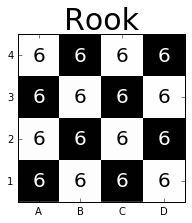

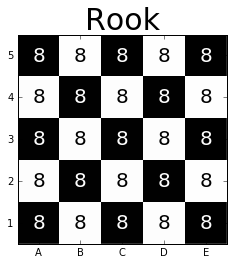

In [13]:
special_cases(piece='Rook', board_sizes=range(4,6))

Известная особенность ладьи - независимо от расположения на доске, она всегда контролирует постоянное количество полей, а именно $2(n-1)$ - это сумма полей по горизонтали и вертикали минус поле, на котором стоит сама ладья.
$$P(X_{rook}) = \frac{n^{2}\cdot 2(n-1)}{n^{2}(n^{2}-1)} = \frac{2}{(n+1)}.$$

## Ферзь

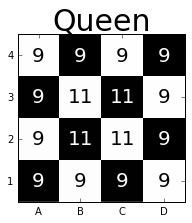

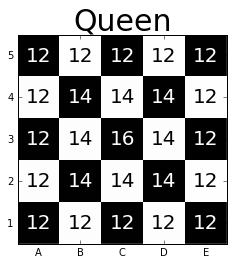

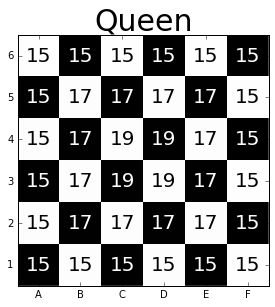

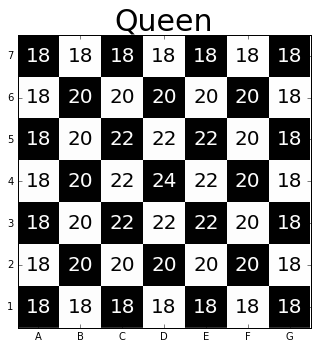

In [14]:
special_cases(piece='Queen', board_sizes=range(4,8))

Поскольку ферзь сочетает в себе возможности офицера и ладьи, выражение для него может быть получено как сумма выражений для этих фигур:

$$ P(X_{queen}) = \frac{2(2n-1)}{3n(n+1)} + \frac{2}{n+1} = \frac{2(2n-1) + 6n}{3n(n+1)} = \frac{{\color{Red} {4n}} - 2 + {\color{Red} {6n}}}{3n(n+1)} = \frac{10n - 2}{3n(n+1)} = \frac{2(5n-1)}{3n(n+1)}. $$

## Король

### Функция, возвращающая массив валентностей Графа короля

In [15]:
def king(valencies):
    
    # corners : top left = top right = \
                # bottom left = bottom right
    valencies[0, 0] = valencies[0, -1] = \
        valencies[-1, 0] = valencies[-1, -1] = 3
    
    # edges : top, left, right, bottom
    valencies[0, 1:-1] = valencies[1:-1, 0] = \
        valencies[1:-1, -1] = valencies[-1, 1:-1] = 5
    
    # center
    valencies[1:-1, 1:-1] = 8
    
    return valencies

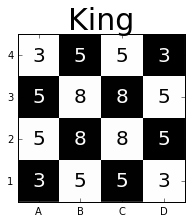

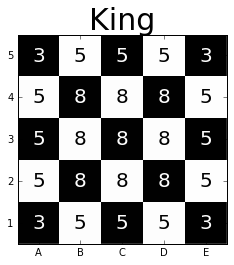

In [16]:
special_cases(piece='King', board_sizes=range(4,6))

Видно, что края доски, за исключением $3$-валентных углов, $5$-валентны, а всё оставшееся пространство $8$-валентно. Ввиду того, что краёв $4$, а $5$-валентных клеток на одном краю $(n-2)$ штук, имеем: $$P(X_{king}) = \frac{4\cdot 3}{n^{2}(n^{2}-1)} +\frac{4(n-2)\cdot 5}{n^{2}(n^{2}-1)} +\frac{(n-2)^2\cdot 8}{n^{2}(n^{2}-1)} = \frac{12 + 20(n-2) + 8(n-2)^2}{n^{2}(n^{2}-1)} = \frac{4(3 + 5(n-2)+2(n-2)^2)}{n^{2}(n^{2}-1)} = \frac{4(3 + 5n-10+2(n^2 - 4n + 4))}{n^{2}(n^{2}-1)} = \frac{4({\color{Green} 3} + {\color{Red} {5n}}-{\color{Green} {10}}+2n^2 - {\color{Red} {8n}} + {\color{Green} {8}} )}{n^{2}(n^{2}-1)} = \frac{4(2n^2 - 3n + 1)}{n^{2}(n^{2}-1)} = \frac{4(2n-1)(n-1)}{n^{2}(n^{2}-1)} = \frac{4(2n-1)}{n^{2}(n+1)}.$$

### Функция, возвращающая значение $P(X_{piece})$

In [17]:
def get_probabilities(piece, n):
    
    # NOTE: Results can be wrong for large n because of dividing by
    # the huge denominator!
    if piece == 'Pawn':
        return 2*(n-1)/((n**2)*(n+1)) 
    
    elif piece == 'Knight':
        return 8*(n-2)/((n**2)*(n+1)) 

    elif piece == 'Bishop':
        return 2*(2*n-1)/(3*n*(n+1)) 
   
    elif piece == 'Rook':
        return 2/(n+1) 

    elif piece == 'Queen':
        return 2*(5*n-1)/(3*n*(n+1)) 

    elif piece == 'King':
        return 4*(2*n-1)/(n**2*(n+1))


Для проверки аналитических результатов используем метод вычисления вероятности «в лоб» - напрямую из массива валентностей.

In [18]:
def straightforward_prob(piece, board_size):
    # Get probability directly from the board of valencies
    board, _ = get_board(board_size)
    val_board = get_valencies(piece, board)
    
    unique, counts = np.unique(val_board, return_counts=True)
    prob = np.dot(unique, counts)/((board_size)**2 * (board_size**2 - 1))
    
    return prob 

График, отображающий зависимость вероятности от размера доски, представлен как функция действительного переменного в целях наглядности.   

Analytical results approved


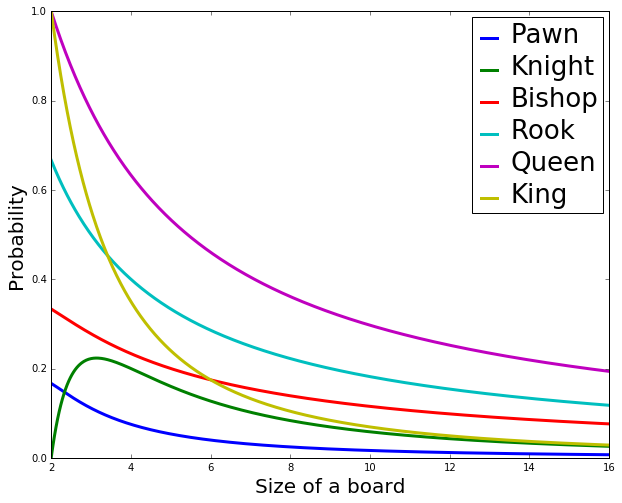

In [19]:
start = 2
end = 16
step = 0.02
x = np.arange(start, end)
names_list = ['Pawn', 'Knight', 'Bishop', 'Rook', 'Queen', 'King']

# Check if analytical results match straightforward calculations
for name in names_list:
    for board_size in x:
        y = get_probabilities(name, board_size)
        if not y == straightforward_prob(name, board_size):
            print('Mistake in equation for %s' % name)
print('Analytical results approved')

# Let's expand the range from Z to R for the sake of visual clarity
x = np.arange(start, end, step)
fig, ax = plt.subplots(figsize=(10, 8))  

for name in names_list:
    y = get_probabilities(name, x)   
    plt.plot(x, y, label=name, linewidth=3.0)
          
legend = plt.legend(loc='upper right')

for label in legend.get_lines():
    label.set_linewidth(3)  

for label in legend.get_texts(): 
    label.set_fontsize(26)

plt.xlabel("Size of a board", fontsize=20)    
plt.ylabel("Probability", fontsize=20)    
plt.show()   